# 3. Using PyROOT with CMS-SW environment

In this example, we will see how to use PyROOT together with CMS-SW packages to manuplate a CMS structured ROOT file. The steps we follow are:
- read the `slimmedJets` and `slimmedMuons` branches in MiniAOD;
- apply event selection:  $ N_{jets} \geq 2 $,  $ N_{\mu} \geq 1 $, $ p_{Tjet1} > 30 $ GeV, $ |\eta_{jet1}| < 4.5 $;
- draw distributions of leading jet pT, leading muon pT and leading two jets invariant mass.

Both ROOT-style code and pythonic code are shown.

In [1]:
import ROOT
from DataFormats.FWLite import Handle, Events # CMSSW package

Welcome to JupyROOT 6.14/09


## ROOT approach

In [2]:
# define histogram before event generation
h_ptj1 = ROOT.TH1F("h_ptj1", "leading jet p_{T};[GeV];Entries", 40, 0., 200.)
h_ptmu1 = ROOT.TH1F("h_ptmu1", "leading muon p_{T};;Entries", 40, 0., 200.)
h_mjj = ROOT.TH1F("h_mjj", "M_{jj};[GeV];Entries", 40, 0., 200.)

# read events
events = Events("/home/cmsdas/public/pre_exercises/root/CMSDataAnaSch_Data_706_MiniAOD.root")
jets = Handle("vector<pat::Jet>")
muons = Handle("vector<pat::Muon>")
for ie, event in enumerate(events): # loop over events
    event.getByLabel("slimmedJets", jets)
    event.getByLabel("slimmedMuons", muons)
    
    # event selection
    if jets.product().size()<2 or muons.product().size()<1 or jets.product().at(0).pt()<30 or abs(jets.product().at(0).eta())>4.5:
        continue
        
    # fill histogram
    h_ptj1.Fill(jets.product().at(0).pt())
    h_ptmu1.Fill(muons.product().at(0).pt())
    h_mjj.Fill((jets.product().at(0).p4()+jets.product().at(1).p4()).M())
    # end the event loop
    
# histogram h_ptj1, h_ptmu1 & h_mjj are now ready

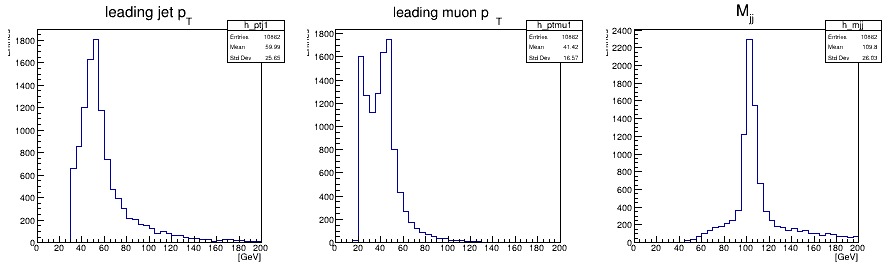

In [3]:
# plotting with ROOT
c = ROOT.TCanvas("c", "c", 900, 300)
c.Divide(3,1)
c.cd(1); h_ptj1.Draw()
c.cd(2); h_ptmu1.Draw()
c.cd(3); h_mjj.Draw()
c.Draw()

## Pythonic approach

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# initialize array for plotting use
slimmedJets = [[], []]
slimmedMuons = []

def toArray(obj): # transform pat::Jet/Muon obj to plain array
    return (obj.px(), obj.py(), obj.pz(), obj.energy())
# read events
events = Events("/home/cmsdas/public/pre_exercises/root/CMSDataAnaSch_Data_706_MiniAOD.root")
jets = Handle("vector<pat::Jet>")
muons = Handle("vector<pat::Muon>")
for ie, event in enumerate(events): # loop over events
    event.getByLabel("slimmedJets", jets)
    event.getByLabel("slimmedMuons", muons)
    
    # append 4-vector value to arries
    slimmedJets[0].append(toArray(jets.product().at(0)) if jets.product().size()>0 else (0.,0.,0.,0.))
    slimmedJets[1].append(toArray(jets.product().at(1)) if jets.product().size()>1 else (0.,0.,0.,0.))
    slimmedMuons.append(toArray(muons.product().at(0)) if muons.product().size()>0 else (0.,0.,0.,0.))
    # end the event loop
    
# array slimmedJets & slimmedMuons are now ready

10882 / 11410 events selected


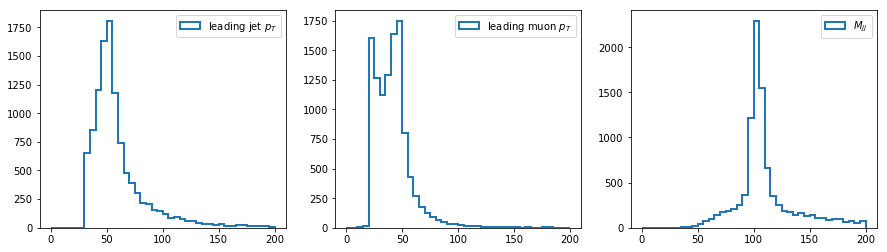

In [5]:
# define selection
nevt = len(slimmedMuons)
selec =[slimmedJets[1][i][0]!=0. and slimmedMuons[i][0]!=0. and \
        ROOT.TLorentzVector(*slimmedJets[0][i]).Pt()>30 and 
        abs(ROOT.TLorentzVector(*slimmedJets[0][i]).Eta())<4.5 for i in range(nevt)]
print("{} / {} events selected".format(len(np.array(slimmedMuons)[selec]), nevt))
# plotting with matplotlib
kwargs = {'bins':40, 'range':(0.,200.), 'histtype':'step', 'linewidth':2}
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.hist(np.array([ROOT.TLorentzVector(*slimmedJets[0][i]).Pt() for i in range(nevt)])[selec], label=r'leading jet $p_T$', **kwargs)
plt.legend()
plt.subplot(1,3,2)
plt.hist(np.array([ROOT.TLorentzVector(*slimmedMuons[i]).Pt() for i in range(nevt)])[selec], label=r'leading muon $p_T$', **kwargs)
plt.legend()
plt.subplot(1,3,3)
plt.hist(np.array([ROOT.TLorentzVector(*(np.array(slimmedJets[0][i])+np.array(slimmedJets[1][i]))).M() for i in range(nevt)])[selec], label=r'$M_{jj}$', **kwargs)
plt.legend()
plt.show()